In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from V_A_change_utils import PDF_hit_V_A_change, CDF_hit_V_A_change
from pyvbmc import VBMC

# Read data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# df

In [3]:
# OFF
df_to_fit  = df[ df['LED_trial'] == 0 ]

# VBMC

In [4]:
T_trunc = 0.3

## loglike fn

In [ ]:
def compute_loglike(row, V_A_old, V_A_new, theta_A):
    t_stim = row['intended_fix']
    RT_wrt_fix = row['timed_fix']
    t_LED = row['LED_onset_time']
    RT_wrt_stim = RT_wrt_fix - t_stim

    if RT_wrt_fix < T_trunc:
        likelihood = 0
    elif RT_wrt_stim < 0: # abort
        # trunc factor
        prob_T_trunc_to_inf = quad(PDF_hit_V_A_change, T_trunc, 10, args=(V_A_old, V_A_new, theta_A, t_LED))[0]
        likelihood = PDF_hit_V_A_change(RT_wrt_fix, V_A_old, V_A_new, theta_A, t_LED)/prob_T_trunc_to_inf 
    elif RT_wrt_stim > 0: # valid trial
        likelihood = quad(PDF_hit_V_A_change, t_stim, 10, args=(V_A_old, V_A_new, theta_A, t_LED))[0]
    else:
        print(f'RT_wrt_stim: {RT_wrt_stim}')


    if likelihood <= 0:
        likelihood = 1e-50
    
    return np.log(likelihood)    


def vbmc_loglike_abort_fn(params):
    V_A_old, V_A_new, theta_A = params # for now, lets ignore NDT

    


    # because there are less aborts, single job runs faster
    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A_old, V_A_new, theta_A)\
                                       for _, row in df_to_fit.iterrows() if not np.isnan(row['timed_fix'] - row['intended_fix']))

    loglike = np.sum(all_loglike)
    return loglike

# bounds, prior

In [6]:
V_A_old_bounds = [0.01, 5]
V_A_new_bounds = [0.01, 5]
theta_A_bounds = [0.01, 5]

V_A_old_plausible_bounds = [0.5,3]
V_A_new_plausible_bounds = [0.5,3]
theta_A_plausible_bounds = [0.5,3]

def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A_old, V_A_new, theta_A = params

    V_A_old_logpdf = trapezoidal_logpdf(V_A_old, V_A_old_bounds[0], V_A_old_plausible_bounds[0], V_A_old_plausible_bounds[1], V_A_old_bounds[1])
    V_A_new_logpdf = trapezoidal_logpdf(V_A_new, V_A_new_bounds[0], V_A_new_plausible_bounds[0], V_A_new_plausible_bounds[1], V_A_new_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])

    return V_A_old_logpdf + V_A_new_logpdf + theta_A_logpdf



# loglike + prior

In [7]:
def vbmc_prior_plus_loglike_fn(params):
        return vbmc_loglike_abort_fn(params) + vbmc_prior_abort_fn(params)

# init and run vbmc

In [8]:
lb = [V_A_old_bounds[0], V_A_new_bounds[0], theta_A_bounds[0]]
ub = [V_A_old_bounds[1], V_A_new_bounds[1], theta_A_bounds[1]]

plb = [V_A_old_plausible_bounds[0], V_A_new_plausible_bounds[0], theta_A_plausible_bounds[0]]
pub = [V_A_old_plausible_bounds[1], V_A_new_plausible_bounds[1], theta_A_plausible_bounds[1]]

np.random.seed(42)
V_A_old_0 = np.random.uniform(V_A_old_plausible_bounds[0], V_A_old_plausible_bounds[1])
V_A_new_0 = np.random.uniform(V_A_new_plausible_bounds[0], V_A_new_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])

x_0 = np.array([V_A_old_0, V_A_new_0, theta_A_0])

vbmc = VBMC(vbmc_prior_plus_loglike_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Casting upper bounds to floating point.
Casting plausible upper bounds to floating point.


KeyboardInterrupt: 

In [ ]:
vbmc.save('vbmc_abort_no_NDT_LED_OFF.pkl')

In [8]:
import pickle
with open('vbmc_abort_no_NDT_LED_OFF.pkl', 'rb') as f:
    vbmc_results = pickle.load(f)

# corner plot

In [9]:
import corner
vp_samples = vbmc_results.vp.sample(int(1e6))[0]

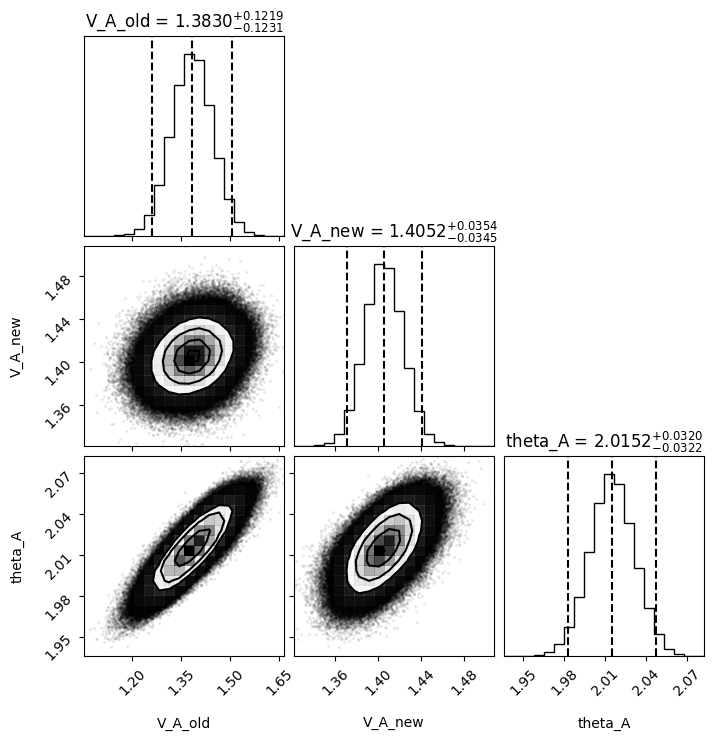

In [10]:
V_A_old_samp = vp_samples[:,0]
V_A_new_samp = vp_samples[:,1]
theta_A_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((V_A_old_samp, V_A_new_samp, theta_A_samp)))
param_labels = ['V_A_old', 'V_A_new', 'theta_A']
corner.corner (combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], title_fmt=".4f"  );

# Are the fits good?

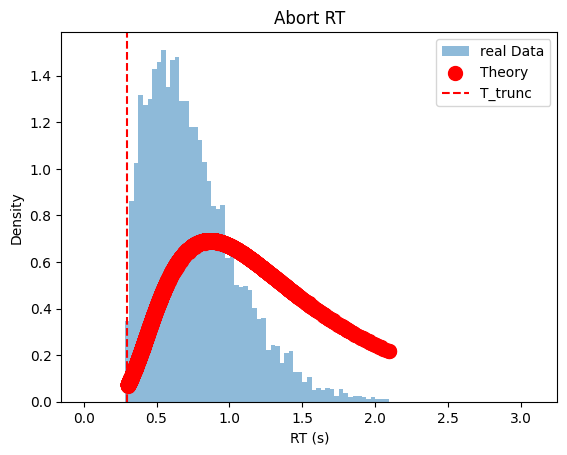

In [ ]:
# data
aborts_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values
bins = np.linspace(0.001, np.max(aborts_rt)+1, 100)

# theory
t_pts = bins[:-1] + np.diff(bins)/2
V_A_old_samp_mean = np.mean(V_A_old_samp); V_A_new_samp_mean = np.mean(V_A_new_samp); theta_A_samp_mean = np.mean(theta_A_samp)
rt_x = []; pdf_y = []
for _, row in df_to_fit.iterrows():
    if row['timed_fix'] < row['intended_fix'] and row['timed_fix'] > T_trunc:
        rt = row['timed_fix']
        t_LED = row['LED_onset_time']

        pdf_trunc_factor = quad(PDF_hit_V_A_change, T_trunc, 10, args=(V_A_old_samp_mean, V_A_new_samp_mean, theta_A_samp_mean, t_LED))[0]
        pdf_rt = PDF_hit_V_A_change(rt, V_A_old_samp_mean, V_A_new_samp_mean, theta_A_samp_mean, t_LED)/pdf_trunc_factor
        
        rt_x.append(rt)
        pdf_y.append(pdf_rt)



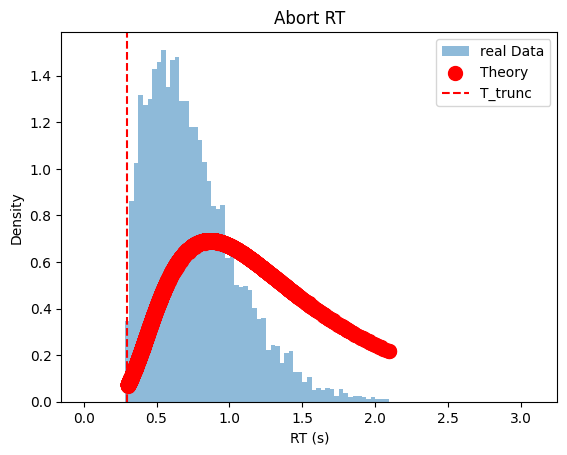

In [14]:

plt.hist(aborts_rt, bins=bins, density=True, alpha=0.5, label='real Data');
plt.scatter(rt_x, pdf_y, color='r', label='Theory', s=100)

plt.xlabel('RT (s)')
plt.ylabel('Density')
plt.title('Abort RT')
plt.axvline(T_trunc, color='r', linestyle='--', label='T_trunc')
plt.legend();

# area checks theory